In [1]:
import dask.dataframe as dd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# JOB WORKLOADS

## Importing data

In [3]:
column_names_s17 = [
  "create_timestamp",
  "modify_timestamp",
  "job_id",
  "task_id",
  "instance_num",
  "status",
  "plan_cpu",
  "plan_mem"
]

column_types_s17 = {
  column_names_s17[0]: 'int64',
  column_names_s17[1]: 'int64',
  column_names_s17[2]: 'int32',
  column_names_s17[3]: 'int32',
  column_names_s17[4]: 'int64',
  column_names_s17[5]: 'string',
  column_names_s17[6]: 'float32',
  column_names_s17[7]: 'float64',
}

df_s17 = dd.read_csv('./s17_batch_task.csv', blocksize=25e8, names=column_types_s17, dtype=column_types_s17)

In [4]:
column_names_s18 = [
    "start_timestamp",
    "end_timestamp",
    "job_id",
    "task_id",
    "machineID",
    "status",
    "seq_no",
    "total_seq_no",
    "real_cpu_max",
    "real_cpu_avg",
    "real_mem_max",
    "real_mem_avg",
]

column_types_s18_i = {
    column_names_s18[0]: object,
    column_names_s18[1]: object,
    column_names_s18[2]: object,
    column_names_s18[3]: object,
    column_names_s18[4]: object,
    column_names_s18[5]: object,
    column_names_s18[6]: object,
    column_names_s18[7]: object,
    column_names_s18[8]: object,
    column_names_s18[9]: object,
    column_names_s18[10]: object,
    column_names_s18[11]: object,
}

df_s18_i = dd.read_csv('./s18_batch_instance.csv', blocksize=25e8, names=column_names_s18, dtype=column_types_s18_i)

column_types_s18 = {
    column_names_s18[0]: 'int64',
    column_names_s18[1]: 'int64',
    column_names_s18[2]: 'int32',
    column_names_s18[3]: 'int32',
    column_names_s18[4]: 'int32',
    column_names_s18[5]: object,
    column_names_s18[6]: 'int32',
    column_names_s18[7]: 'int32',
    column_names_s18[8]: 'float32',
    column_names_s18[9]: 'float32',
    column_names_s18[10]: 'float64',
    column_names_s18[11]: 'float64',
}

df_s18 = df_s18_i.fillna(-1).astype(column_types_s18)

In [4]:
# df_s17.shape[0].compute()

# df_s17['job_id'].nunique().compute()

# df_s17.query('job_id == ').compute()

## Numbers in Brief

In [5]:
tasks_per_job = df_s17.groupby('job_id')['task_id'].count()

In [6]:
tasks_per_job_mean = tasks_per_job.mean().compute()
tasks_per_job_max = tasks_per_job.max().compute()
tasks_per_job_min = tasks_per_job.min().compute()

### Tasks per Job

In [7]:
tasks_per_job_mean, tasks_per_job_max, tasks_per_job_min

(6.219828584665277, 156, 1)

In [8]:
# df_s17.query('task_id == 2').compute()

In [9]:
instances_per_task = df_s17.groupby('task_id')['instance_num'].sum()

In [10]:
instances_per_task_mean = instances_per_task.mean().compute()
instances_per_task_max = instances_per_task.max().compute()
instances_per_task_min = instances_per_task.min().compute()

### Instances per Task

In [11]:
instances_per_task_mean, instances_per_task_max, instances_per_task_min

(147.84453713704022, 64486, 1)

In [12]:
instances_per_job = df_s17.groupby('job_id')['instance_num'].sum()

In [13]:
instances_per_job_mean = instances_per_job.mean().compute()
instances_per_job_max = instances_per_job.max().compute()
instances_per_job_min = instances_per_job.min().compute()

## Instances per Job

In [14]:
instances_per_job_mean, instances_per_job_max, instances_per_job_min

(919.5676781715698, 66632, 1)

### Total Jobs in Alibaba 2017 data for job traces

In [15]:
no_of_jobs_in_alibaba_17 = df_s17['job_id'].nunique().compute()
no_of_jobs_in_alibaba_17

12951

In [16]:
total_vms = df_s18['machineID'].replace(-1, np.NaN).nunique().compute()

### Total no of VMs in Alibaba 2017 data for job traces

In [17]:
total_vms

1293

### Job execution time v resource utilization

## Execution Time

### Job duration

In [8]:
job_end = df_s18[['end_timestamp', 'job_id']].replace(-1, np.NaN).dropna().groupby('job_id').max().compute()

In [6]:
job_start = df_s17[['job_id', 'create_timestamp']].replace(-1, np.NaN).groupby('job_id').min().compute()
job_end_2 = df_s17[['job_id', 'modify_timestamp']].replace(-1, np.NaN).groupby('job_id').max().compute()

## modify timestamps > end timestamps 

Modify timestamps in the `batch_tasks` seems to have the values greater than or equal values compared to the `end_timestamp` values

the difference can be seen in the below output where the `job_end_2` from `batch_tasks` have 12893 values greater than or equal to 

In [9]:
(job_end['end_timestamp'].astype('int64') <= job_end_2['modify_timestamp']).value_counts()

True     12893
False       58
dtype: int64

In [10]:
exec_each_job = dd.from_array(job_end_2['modify_timestamp'] - job_start['create_timestamp'], columns={"execution_time": 'int64'}).compute()

<AxesSubplot:xlabel='execution_time', ylabel='Proportion'>

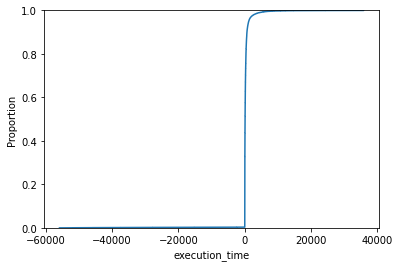

In [11]:
sns.ecdfplot(data=exec_each_job, x="execution_time")

> Some values in the `batch_tasks` modify_timestamp are 0 but the create timestamps are in 57000 which lead to closely -60000 values being shown in the CDF. So below is the plot where negatives values are cutoff

## CDF of Job Duration

<AxesSubplot:xlabel='execution_time', ylabel='Proportion'>

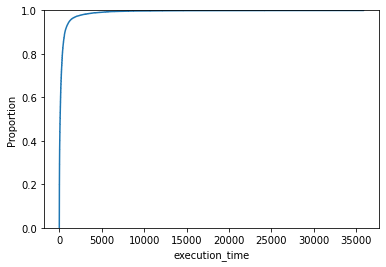

In [12]:
sns.ecdfplot(data=exec_each_job[exec_each_job['execution_time'] >= 0], x="execution_time")

> Although there are `12893` jobs with end timestamp from batch_tasks being more accurate than batch_instances, we got 12906 with non negative execution times. This maybe because of the 0.1% of `12893` (~13 records) with negative timestamps which match the exact calculation

In [13]:
len(exec_each_job[exec_each_job['execution_time'] >= 0])

12906

In [16]:
job_start.min(), job_end_2.max()

(create_timestamp   -1078
 dtype: int64,
 modify_timestamp    61668
 dtype: int64)

In [19]:
df_s17['instance_num'].min().compute(), df_s17['instance_num'].max().compute()

(1, 64486)

In [14]:
tasks_each_job = df_s17[['job_id', 'task_id']].groupby('job_id').count().compute()

In [15]:
tasks_each_job = tasks_each_job.rename(columns = {'task_id': 'tasks_num'})

In [16]:
tasks_each_job

,tasks_num
job_id,
1,1
2,2
3,2
4,2
5,2
...,...
12947,6
12948,6
12949,6


In [ ]:
# sns.scatterplot(data=tasks_each_job, )

In [17]:
exec_e_j_c = exec_each_job[exec_each_job['execution_time'] >= 0]

In [19]:
exec_v_tasks_each_job = dd.concat([exec_e_j_c, tasks_each_job], axis=1, join='inner').compute()

**Execution time v num of Tasks**

<AxesSubplot:xlabel='tasks_num', ylabel='execution_time'>

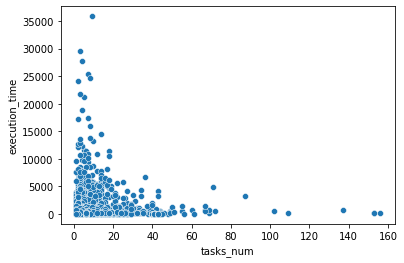

In [20]:
sns.scatterplot(data=exec_v_tasks_each_job, y="execution_time", x="tasks_num")

**Correlation between num of tasks and execution time**

In [21]:
exec_v_tasks_each_job['tasks_num'].corr(exec_v_tasks_each_job['execution_time'])

0.054214873604556915

The correlation is low and close to zero. So we can conclude that number of tasks in a job doesnt impact the execution time of the jobs

### TODO

* [ ] check if starting timestamps for all task instances in the s_18 data are same
* [ ] find the sizes of the maximun values in each column to assign the datatypes
* [x] Find out the timestamp unit - (it is in seconds)

## Resource Demand

In [5]:
plan_res_job = df_s17[['job_id', 'plan_cpu', 'plan_mem']].dropna().groupby('job_id').mean()

In [6]:
plan_res_job

,plan_cpu,plan_mem
npartitions=1,,
,float64,float64
,...,...


<AxesSubplot:xlabel='plan_cpu', ylabel='Proportion'>

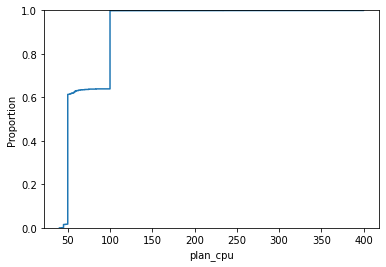

In [7]:
sns.ecdfplot(data=plan_res_job, x='plan_cpu' )

<AxesSubplot:xlabel='plan_mem', ylabel='Proportion'>

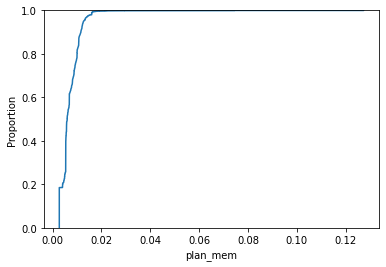

In [8]:
sns.ecdfplot(data=plan_res_job, x='plan_mem' )

In [6]:
usage_res_job = df_s18[['job_id', 'real_cpu_avg', 'real_mem_avg']].replace(-1, np.NaN).dropna().groupby('job_id').mean()

<AxesSubplot:xlabel='real_cpu_avg', ylabel='Proportion'>

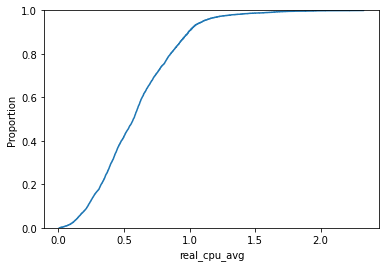

In [12]:
sns.ecdfplot(data=usage_res_job, x='real_cpu_avg' )

<AxesSubplot:xlabel='real_mem_avg', ylabel='Proportion'>

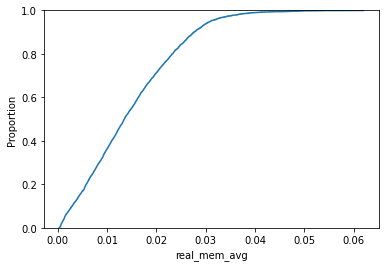

In [13]:
sns.ecdfplot(data=usage_res_job, x='real_mem_avg' )

<AxesSubplot:xlabel='real_mem_avg', ylabel='Count'>

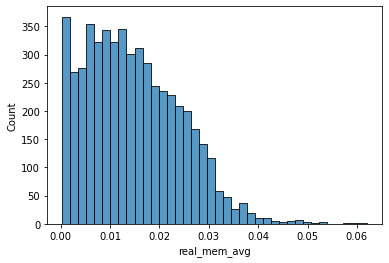

In [14]:
sns.histplot(data=usage_res_job, x='real_mem_avg' )

<AxesSubplot:xlabel='real_mem_avg', ylabel='real_cpu_avg'>

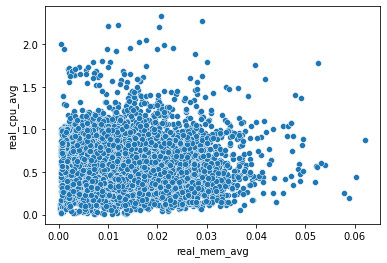

In [7]:
sns.scatterplot(data=usage_res_job, x='real_mem_avg', y='real_cpu_avg')

The correlation is very low implying that the cpu and memory usage are not correlated

This could mean that the workloads are maybe either compute intensive or memory intensive

In [12]:
usage_res_job_c = usage_res_job.compute()
usage_res_job_c['real_mem_avg'].corr(usage_res_job_c['real_cpu_avg'])

-0.033302772777511036

In [13]:
plan_res_t = df_s17[['task_id', 'plan_cpu', 'plan_mem']].dropna().groupby('task_id').mean()

<AxesSubplot:xlabel='plan_cpu', ylabel='Proportion'>

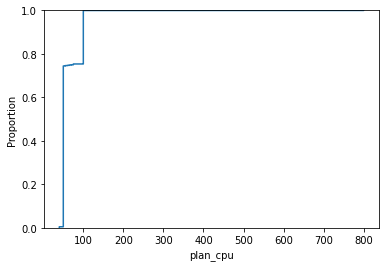

In [14]:
sns.ecdfplot(data=plan_res_t, x='plan_cpu' )

<AxesSubplot:xlabel='plan_mem', ylabel='Proportion'>

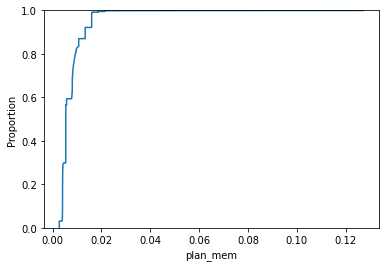

In [15]:
sns.ecdfplot(data=plan_res_t, x='plan_mem' )

In [17]:
usage_res_t = df_s18[['task_id', 'real_cpu_avg', 'real_mem_avg']].replace(-1, np.NaN).dropna().groupby('task_id').mean()

<AxesSubplot:xlabel='real_cpu_avg', ylabel='Proportion'>

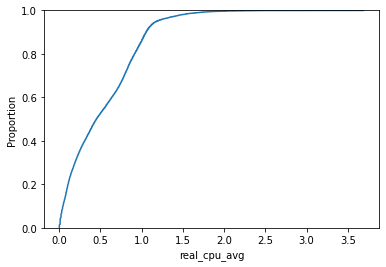

In [18]:
sns.ecdfplot(data=usage_res_t, x='real_cpu_avg' )

<AxesSubplot:xlabel='real_mem_avg', ylabel='Proportion'>

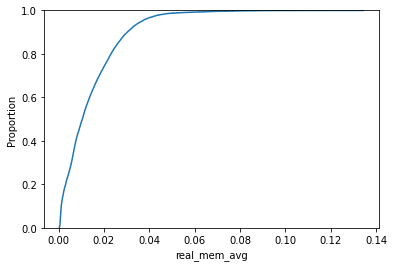

In [19]:
sns.ecdfplot(data=usage_res_t, x='real_mem_avg' )

In [18]:
df_s17.head()

,create_timestamp,modify_timestamp,job_id,task_id,instance_num,status,plan_cpu,plan_mem
0,6459,6524,3,4,15740,Terminated,50.0,0.007957
1,6457,6533,3,5,1,Terminated,50.0,0.004395
2,6036,6046,4,7,393,Waiting,NaN,NaN
3,6036,6046,4,6,452,Waiting,NaN,NaN
4,10719,11332,15,67,1705,Terminated,50.0,0.005736


In [22]:
df_s17.query('status == "Running"').compute().head()

,create_timestamp,modify_timestamp,job_id,task_id,instance_num,status,plan_cpu,plan_mem
33,16341,16391,28,151,61,Running,50.0,0.007936
35,16341,16391,28,152,23,Running,50.0,0.013356
36,16341,16391,28,154,261,Running,50.0,0.008205
139,24775,24927,61,438,319,Running,50.0,0.013356
140,24775,24927,61,446,3,Running,50.0,0.007952


In [23]:
df_s17.query('job_id == 28').compute()

,create_timestamp,modify_timestamp,job_id,task_id,instance_num,status,plan_cpu,plan_mem
33,16341,16391,28,151,61,Running,50.0,0.007936
34,16341,16391,28,153,407,Failed,50.0,0.016007
35,16341,16391,28,152,23,Running,50.0,0.013356
36,16341,16391,28,154,261,Running,50.0,0.008205


In [4]:
j28_t_151 = df_s18.query('job_id == 28 & task_id == 151').compute()
j28_t_151

,start_timestamp,end_timestamp,job_id,task_id,machineID,status,seq_no,total_seq_no,real_cpu_max,real_cpu_avg,real_mem_max,real_mem_avg
10757599,16348,16391,28,151,742,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757600,16348,16391,28,151,786,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757601,16348,16391,28,151,302,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757602,16348,16391,28,151,159,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757603,16348,16391,28,151,149,Running,1,1,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10757679,16348,16391,28,151,572,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757680,16348,16391,28,151,612,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757681,16348,16391,28,151,1095,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757682,16348,16391,28,151,819,Running,1,1,-1.0,-1.0,-1.0,-1.0


In [ ]:
# df_s18.groupby('job_id')['real_cpu_avg'].mean()

df_cdf_mem = df_s18.replace(-1, np.NaN).dropna().groupby('job_id')['real_mem_avg'].mean().compute()

In [7]:
j28_t_151.replace(-1, np.NaN)['real_mem_avg'].mean()

nan

In [11]:
non_nan = df_s18.replace(-1, np.NaN).dropna().head()

In [12]:
non_nan

,start_timestamp,end_timestamp,job_id,task_id,machineID,status,seq_no,total_seq_no,real_cpu_max,real_cpu_avg,real_mem_max,real_mem_avg
4214,16218.0,16248.0,239.0,1328.0,1214.0,Terminated,1,1,0.94,0.04,0.007589,0.007346
4215,16218.0,16248.0,239.0,1328.0,348.0,Terminated,1,1,0.87,0.04,0.007527,0.007284
4216,16218.0,16248.0,239.0,1328.0,736.0,Terminated,1,1,1.00,0.04,0.008397,0.008164
4217,16218.0,16247.0,239.0,1328.0,745.0,Terminated,1,1,0.86,0.03,0.008589,0.008392
4218,16218.0,16248.0,239.0,1328.0,1100.0,Terminated,1,1,0.93,0.04,0.009562,0.009329


In [14]:
test = dd.concat([non_nan, j28_t_151])

In [22]:
test.compute().replace(-1, np.NaN).dropna().groupby('job_id')[['real_mem_avg', 'real_cpu_avg']].mean()

,real_mem_avg,real_cpu_avg
job_id,,
239.0,0.008103,0.038


In [ ]:
mem_and_cpu_per_job = df_s18.replace(-1, np.NaN).dropna().groupby('job_id').[['real_mem_avg', 'real_cpu_avg']].mean()

In [4]:
failed_28 = df_s18.query('job_id == 28 & task_id == 153').compute()

In [7]:
failed_28.query('status == "Failed"')

,start_timestamp,end_timestamp,job_id,task_id,machineID,status,seq_no,total_seq_no,real_cpu_max,real_cpu_avg,real_mem_max,real_mem_avg
10757571,16349,0,28,153,725,Failed,1,1,-1.0,-1.0,-1.0,-1.0


In [9]:
failed_28['end_timestamp'].max()

16391

In [10]:
failed_28['start_timestamp'].min()

16349

In [13]:
j_28 = df_s18.query('job_id == 28').compute()

In [14]:
j_28_min_exec, j_28_max_exec = j_28['start_timestamp'].min(), j_28['end_timestamp'].max()

In [15]:
j_28_min_exec, j_28_max_exec

(16348, 16391)

In [16]:
j_28

,start_timestamp,end_timestamp,job_id,task_id,machineID,status,seq_no,total_seq_no,real_cpu_max,real_cpu_avg,real_mem_max,real_mem_avg
10757402,16349,16391,28,153,290,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757403,16349,16391,28,153,702,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757404,16349,16391,28,153,1215,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757405,16349,16391,28,153,1131,Running,1,1,-1.0,-1.0,-1.0,-1.0
10757406,16349,16391,28,153,959,Running,1,1,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10758149,16348,16391,28,154,693,Running,1,1,-1.0,-1.0,-1.0,-1.0
10758150,16348,16391,28,154,884,Running,1,1,-1.0,-1.0,-1.0,-1.0
10758151,16348,16391,28,154,831,Running,1,1,-1.0,-1.0,-1.0,-1.0
10758152,16348,16391,28,154,32,Running,1,1,-1.0,-1.0,-1.0,-1.0
